In [13]:
import laser_cutter_util
import decode
from matplotlib import pyplot as plt
import numpy as np

In [30]:
with open("/home/bagel/scad/HHD_bay.dxf", "r") as f:
    lines = laser_cutter_util.ParserDxf(f.read())
pieces = laser_cutter_util.SplitToPieces(lines)

In [10]:
with open("/home/bagel/scad/limesdr_case_etch.dxf", "r") as f:
    lines = laser_cutter_util.ParserDxf(f.read())
etch_pieces = laser_cutter_util.SplitToPieces(lines)

In [128]:
new_pieces = []
for i in range(3):
    for j in pieces:
        new_pieces.append(laser_cutter_util.CopyPiece(j))
        laser_cutter_util.TranslatePiece(new_pieces[-1], 0, i*133)

(-53.817, 219.577, -69.005, 129.105)

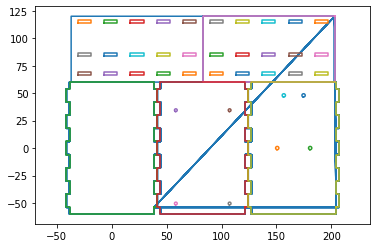

In [85]:
for i in pieces:
    x = []
    y = []
    for j in i:
        x.append(j.a.x)
        y.append(j.a.y)
        x.append(j.b.x)
        y.append(j.b.y)
    plt.plot(x,y)
plt.axis("equal")

(-53.817, 219.577, -69.005, 129.105)

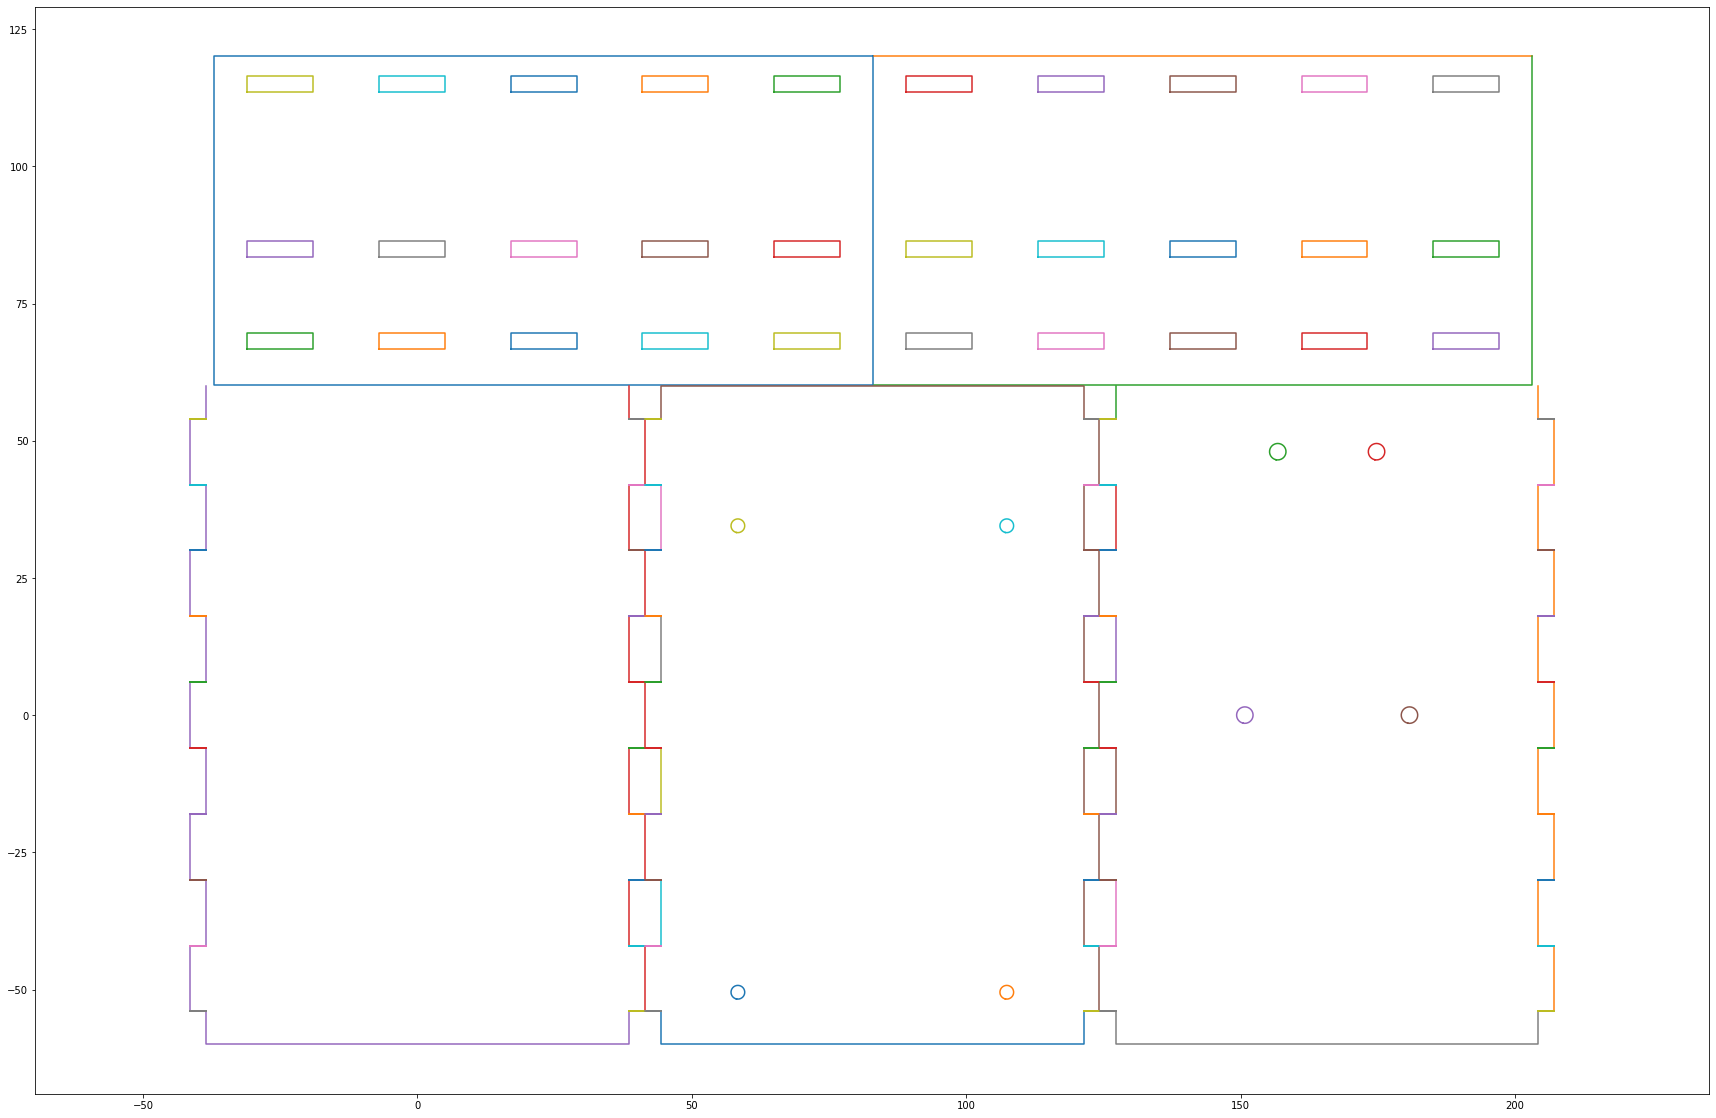

In [84]:
def check_piece_overlap(p1,p2):
    for i in p1:
        for j in p2:
            if laser_cutter_util.LineOverlap(i, j):
                return True
    return False


new_pieces = []
new_pieces.append(pieces[0])
for next_piece in pieces[1:]:
    any_overlap = False
    for match_piece in new_pieces:
        if check_piece_overlap(next_piece, match_piece):
            match_piece.extend(next_piece)
            any_overlap = True
            break
    if not any_overlap:
        new_pieces.append(next_piece)

merged_pieces = []
for i in new_pieces:
    merged_pieces.append([])
    for j in i:
        skip = False
        if j.length() > 5:
            for k in merged_pieces[-1]:
                if laser_cutter_util.LineOverlap(j, k) and k.length() > j.length() * 0.4:
                    skip=True
                    break
        if not skip:
            merged_pieces[-1].append(j)

new_pieces = merged_pieces

cleaned_pieces = []
for i in new_pieces:
    cleaned_pieces.append([])
    for j in i:
        if cleaned_pieces[-1] and laser_cutter_util.line(0, j.a, cleaned_pieces[-1][-1].b).length() > 0.3:
            cleaned_pieces.append([])
        cleaned_pieces[-1].append(j)

new_pieces = cleaned_pieces
        
plt.figure(figsize=(30,20))
for i in new_pieces:
    x = []
    y = []
    for j in i:
        x.append(j.a.x)
        y.append(j.a.y)
        x.append(j.b.x)
        y.append(j.b.y)
    plt.plot(x,y)
plt.axis("equal")

In [31]:
def area(p):
    return 0.5 * abs(sum(line.a.x*line.b.y - line.b.x*line.a.y for line in p))
areas = []
for p in pieces:
    areas.append(area(p))
sorted_pieces = [pieces[i] for i in np.argsort(areas)]

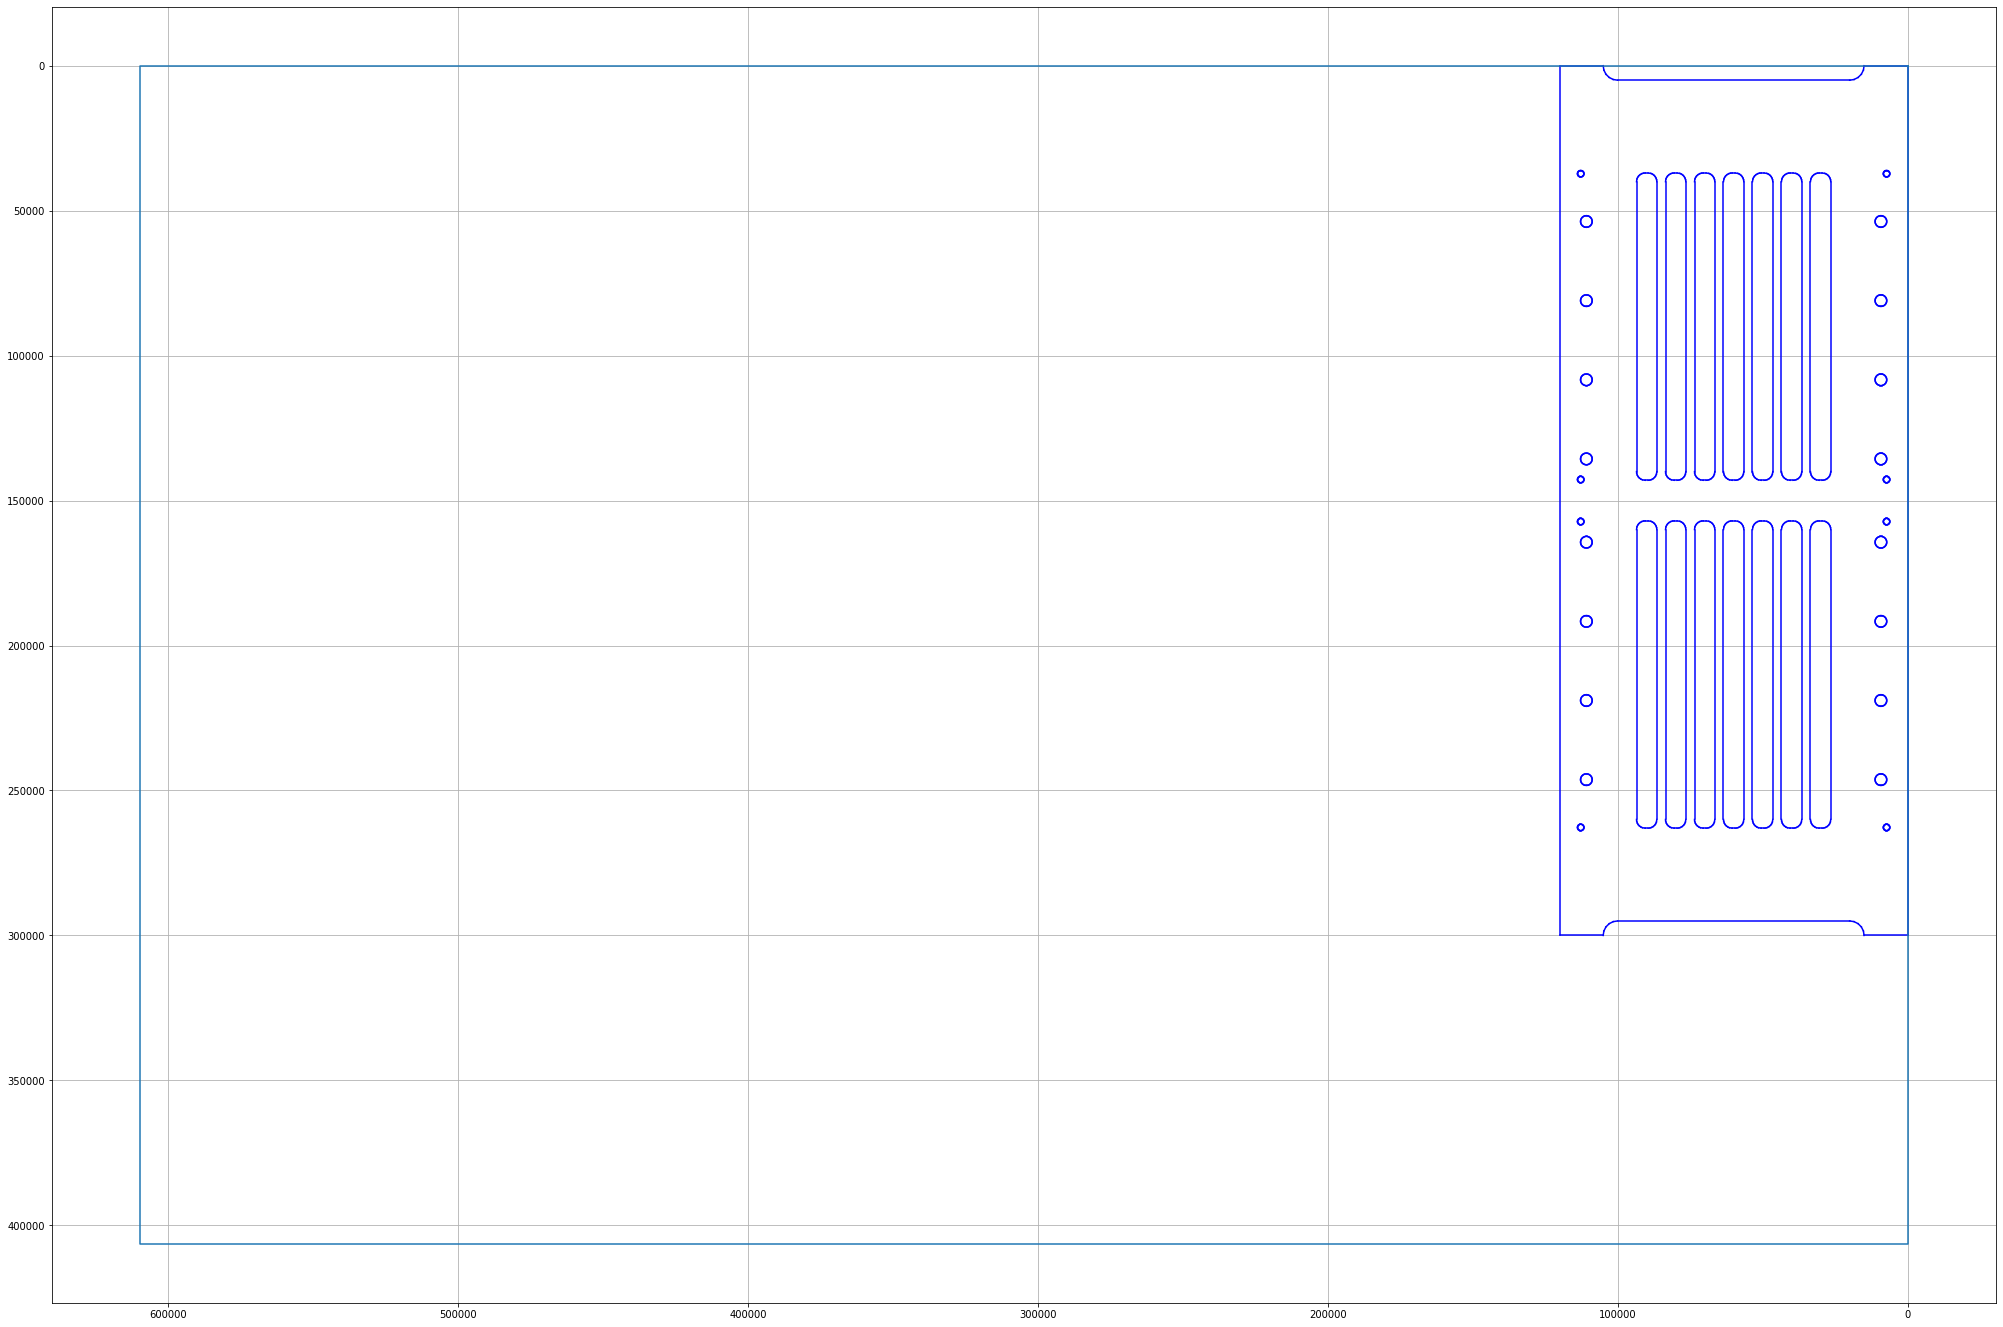

In [32]:
# Output file inspection
layers = [
    laser_cutter_util.layer(
        color=(0,0,1),
        power=70,
        speed=7,
        pieces = sorted_pieces
    )
]

laser_cut_data = laser_cutter_util.CreateLaserCutData(layers)

cmds = decode.parse_msgs(decode.split_msg(decode.unscramble(laser_cut_data)))
laser_sim = decode.LaserSimulator()


for i in cmds:
    if isinstance(i, decode.CmdMsg):
        i.update(laser_sim)
laser_sim.show()

plt.plot([0, 0, 25.4 * 24 * 1000, 25.4 * 24 * 1000, 0],
         [0, 25.4 * 16 * 1000, 25.4 * 16 * 1000, 0, 0])

In [33]:
with open("/home/bagel/scad/hhd_bay.rd", "wb") as f:
    f.write(laser_cut_data)